In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'

In [3]:
def load_data(train_batch_size, test_batch_size):
   
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1309,), (0.3083,))
                       ])),
        batch_size=train_batch_size, shuffle=True)

  
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1309,), (0.3083,))
        ])),
        batch_size=test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [4]:


class Le_Net(nn.Module):
    def __init__(self):
        super(Le_Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
       
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x



In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
train_batch_size = 64
test_batch_size = 1000
train_loader, test_loader = load_data(train_batch_size, test_batch_size)


In [7]:
def train(model, optimizer, epoch, train_loader, log_interval):
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    n_correct = 0
    training_loss = 0
    counter = 0
    n_samples = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        counter += 1
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        training_loss += loss.data

        pred = np.argmax(output.data, axis=1)
        n_samples += target.size(0)
        n_correct += (pred == target).sum().item()
        acc = 100.0 * n_correct / n_samples

        
        if batch_idx % log_interval == 0:
            print('  Train_set, epoch # {} [{}/{}]\tLoss: {:.7f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                loss.data))
            print("  TRAINING_ACCURACY: ", round(acc,2))
    training_loss /= counter
    return training_loss, round(acc,2)

In [8]:
def test(model, epoch, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

    for data, target in test_loader:
        data, target = Variable(data), Variable(target)
        
        output = model(data)
        test_loss += loss_fn(output, target).data

        pred = np.argmax(output.data, axis=1)
        correct = correct + np.equal(pred, target.data).sum()

    # Print log
    test_loss /= len(test_loader.dataset)
    print('\n ##### TEST SET -- EPOCH # {} , AVERAGE LOSS --> {:.7f}, ACCURACY, % {}/{} ({:.2f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
torch.manual_seed(1)
model= Le_Net()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model.parameters(), lr, momentum)
m0_loss_arr = []
m0_acc_arr = []

epochs = 10
log_interval = 200
for epoch in range(1, epochs):
    loss, acc = train(model, optimizer, epoch, train_loader, log_interval)
    m0_loss_arr.append(loss)
    m0_acc_arr.append(acc)
    test(model, epoch, test_loader)

  Train_set, epoch # 1 [0/60000]	Loss: 2.3222549
  TRAINING_ACCURACY:  10.94
  Train_set, epoch # 1 [12800/60000]	Loss: 0.3916689
  TRAINING_ACCURACY:  46.36
  Train_set, epoch # 1 [25600/60000]	Loss: 0.3153257
  TRAINING_ACCURACY:  66.01
  Train_set, epoch # 1 [38400/60000]	Loss: 0.2538003
  TRAINING_ACCURACY:  74.49
  Train_set, epoch # 1 [51200/60000]	Loss: 0.2570684
  TRAINING_ACCURACY:  79.27


C:\Users\91830\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



 ##### TEST SET -- EPOCH # 1 , AVERAGE LOSS --> 0.1385429, ACCURACY, % 9586/10000 (95.86%)

  Train_set, epoch # 2 [0/60000]	Loss: 0.1592590
  TRAINING_ACCURACY:  93.75
  Train_set, epoch # 2 [12800/60000]	Loss: 0.1255757
  TRAINING_ACCURACY:  95.34
  Train_set, epoch # 2 [25600/60000]	Loss: 0.3682039
  TRAINING_ACCURACY:  95.64
  Train_set, epoch # 2 [38400/60000]	Loss: 0.0926343
  TRAINING_ACCURACY:  95.89
  Train_set, epoch # 2 [51200/60000]	Loss: 0.1074334
  TRAINING_ACCURACY:  96.1

 ##### TEST SET -- EPOCH # 2 , AVERAGE LOSS --> 0.0784896, ACCURACY, % 9756/10000 (97.56%)

  Train_set, epoch # 3 [0/60000]	Loss: 0.0255673
  TRAINING_ACCURACY:  100.0
  Train_set, epoch # 3 [12800/60000]	Loss: 0.0836989
  TRAINING_ACCURACY:  97.26
  Train_set, epoch # 3 [25600/60000]	Loss: 0.0495221
  TRAINING_ACCURACY:  97.28
  Train_set, epoch # 3 [38400/60000]	Loss: 0.0342721
  TRAINING_ACCURACY:  97.38
  Train_set, epoch # 3 [51200/60000]	Loss: 0.0742604
  TRAINING_ACCURACY:  97.41

 ##### TEST 

In [10]:


torch.manual_seed(1)

model_1= CNN()

lr = 0.01
momentum = 0.5
optimizer = optim.SGD(model_1.parameters(), lr=lr, momentum=momentum)
m1_loss_arr = []
m1_acc_arr = []

epochs = 10
log_interval = 100
for epoch in range(1, epochs):
    loss, acc = train(model_1, optimizer, epoch, train_loader, log_interval=log_interval)
    m1_loss_arr.append(loss)
    m1_acc_arr.append(acc)
    test(model_1, epoch, test_loader)



  Train_set, epoch # 1 [0/60000]	Loss: 2.3255408
  TRAINING_ACCURACY:  3.12
  Train_set, epoch # 1 [6400/60000]	Loss: 1.3858713
  TRAINING_ACCURACY:  26.96
  Train_set, epoch # 1 [12800/60000]	Loss: 0.9578539
  TRAINING_ACCURACY:  47.53
  Train_set, epoch # 1 [19200/60000]	Loss: 0.6114345
  TRAINING_ACCURACY:  58.51
  Train_set, epoch # 1 [25600/60000]	Loss: 0.3942804
  TRAINING_ACCURACY:  65.12
  Train_set, epoch # 1 [32000/60000]	Loss: 0.2658041
  TRAINING_ACCURACY:  69.46
  Train_set, epoch # 1 [38400/60000]	Loss: 0.5714220
  TRAINING_ACCURACY:  72.81
  Train_set, epoch # 1 [44800/60000]	Loss: 0.3259417
  TRAINING_ACCURACY:  75.38
  Train_set, epoch # 1 [51200/60000]	Loss: 0.2814183
  TRAINING_ACCURACY:  77.33
  Train_set, epoch # 1 [57600/60000]	Loss: 0.4809201
  TRAINING_ACCURACY:  78.97

 ##### TEST SET -- EPOCH # 1 , AVERAGE LOSS --> 0.1257677, ACCURACY, % 9609/10000 (96.09%)

  Train_set, epoch # 2 [0/60000]	Loss: 0.2163359
  TRAINING_ACCURACY:  95.31
  Train_set, epoch # 2 [64

Text(0.5, 1.0, 'MNIST CNN')

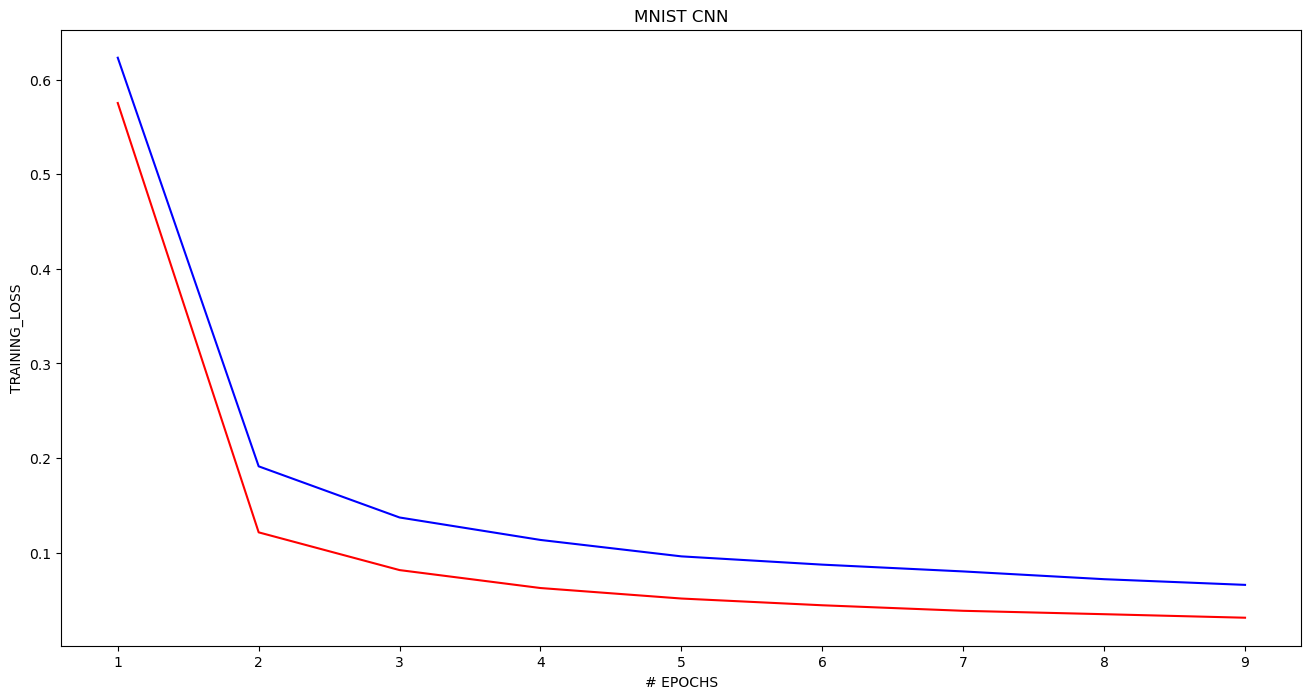

In [17]:
plt.figure(figsize=(16,8))
#plt.plot(model_loss, "ro")
plt.plot(np.arange(1, 10, 1), m0_loss_arr, color = "r")
plt.plot(np.arange(1, 10, 1), m1_loss_arr, color = "b")
plt.xlabel("# EPOCHS")
plt.ylabel("TRAINING_LOSS")
plt.title("MNIST CNN")



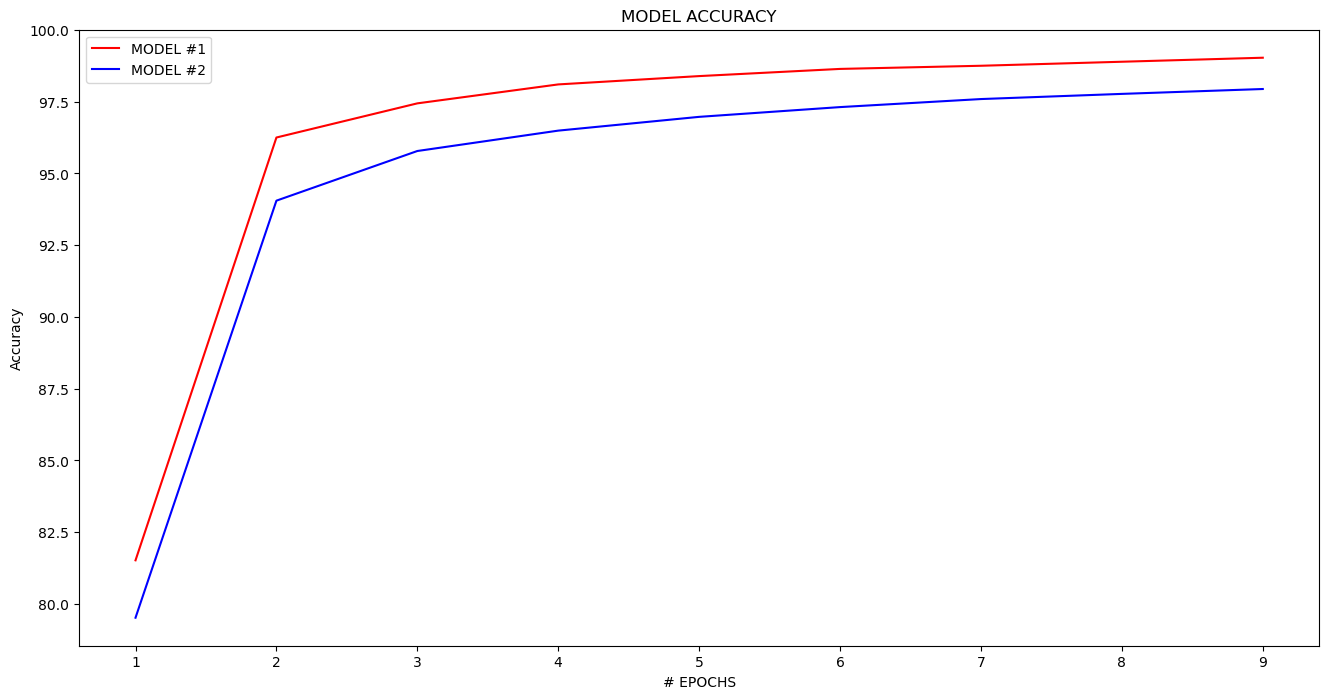

In [20]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(1, 10, 1), m0_acc_arr, color = "r")
plt.plot(np.arange(1, 10, 1), m1_acc_arr, color = "b")
plt.title('MODEL ACCURACY')
plt.legend(['MODEL #1', 'MODEL #2'])
plt.xlabel('# EPOCHS')
plt.ylabel('Accuracy')
plt.show()